In [1]:
#Disaster Tweet Analysis
#Created by: Jinguang Chai, Ryo Matsumoto, Sofia Maysenhalder, Michelle McKenzie,
#            Canh Nguyen, Devin Schubert, and Ken Taniguchi
#ECS 171 - Professor Rafatirad
import numpy as np
import pandas as pd
import re

# NLP Packages
from nltk.corpus import stopwords
from collections import Counter
import string

import matplotlib.pyplot as plt

import nltk
from nltk.stem import WordNetLemmatizer 
from nltk import WhitespaceTokenizer
from nltk.corpus import wordnet
nltk.download('averaged_perceptron_tagger')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn import model_selection,naive_bayes
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/michelle/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [2]:

#This is where the data cleaning and lemmatiztion occurs

# I will replace all these punctuation with ''
punctuation = '["\'?,\.!=><#$%^&*()-+@[]\{\}_~`]'
# Add any words you want to be replaced and the conversion
abbr_dict = {
    "'til": "until",
    "'ll": " will",
    "y'all": "you all",
    "that's": "that is",
    "won't": "will not",
    "can't": "can not",
    "cannot": "can not",
    "ain't": "am not",
    "n't": " not",  # wasn't weren't haven't didn't
    "'ve": " have",  # i've we've you've would've
    "'d": " would",  # you'd i'd we'd you'd
    "'re": " are",  # they're we're you're
    "in'": "ing",  # lookin'

    "what's": "what is",
    "what're": "what are",
    "who's": "who is",
    "who're": "who are",
    "where's": "where is",
    "where're": "where are",
    "when's": "when is",
    "when're": "when are",
    "how's": "how is",
    "how're": "how are",

    "i'm": "i am",
    "we're": "we are",
    "you're": "you are",
    "they're": "they are",
    "it's": "it is",
    "he's": "he is",
    "she's": "she is",
    "that's": "that is",
    "there's": "there is",
    "there're": "there are",

    "i've": "i have",
    "we've": "we have",
    "you've": "you have",
    "they've": "they have",
    "who've": "who have",
    "would've": "would have",
    "not've": "not have",

    "i'll": "i will",
    "we'll": "we will",
    "you'll": "you will",
    "he'll": "he will",
    "she'll": "she will",
    "it'll": "it will",
    "they'll": "they will",

    "isn't": "is not",
    "wasn't": "was not",
    "aren't": "are not",
    "weren't": "were not",
    "can't": "can not",
    "couldn't": "could not",
    "don't": "do not",
    "dont": "do not",
    "didn't": "did not",
    "shouldn't": "should not",
    "wouldn't": "would not",
    "doesn't": "does not",
    "haven't": "have not",
    "hasn't": "has not",
    "hadn't": "had not",
    "won't": "will not",
    "#": "",
    punctuation: '',
    '\s+': ' ',  # replace multi space with one single space

}
adjectives = {
    " angry ": ' ',
    " brave ": ' ',
    " careful ": ' ',
    " healthy ": ' ',
    " little ": ' ',
    " old ": ' ',
    " generous ": ' ',
    " tall ": ' ',
    " good ": ' ',
    " big ": ' ',
    " small ": ' ',
    " am ": ' ',
}
pronouns = {
    " i ": '',
    " he ": '',
    " she ": '',
    " its ": '',
    " me ": '',
    " my ": '',
    " that ": '',
    " they ": '',
    " this ": '',
    " those ": '',
    " im ": '',
    " u ": ''
}

articles = {
    " the ": ' ',
    " a ": ' ',
    " an ": ' ',
}

# Reads the data, converts to lowercase, and replaces using abbreviation list


def process_data(file_name):
    data = pd.read_csv(file_name)
    data.text = data.text.str.lower()  # convert tweet to lower case
    data.text = data.text.str.replace('\d+', '')  # remove numbers
    #data.keyword = data.keyword.str.lower()  # convert keyword to lower case
    data.text = data.text.astype(str)  # cast tweet as a string
    data.keyword = data.keyword.astype(str)
    data.replace(abbr_dict, regex=True, inplace=True)
    data.replace(pronouns, regex=True, inplace=True)
    data.replace(articles, regex=True, inplace=True)
    
    # remove http or https links from tweets
    for sentence in range(len(data['text'])):
        data['text'][sentence] = re.sub(r"http\S+", "", data['text'][sentence])
    data["text"] = data['text'].str.replace('[^\w\s]','')
    return data


In [3]:
#Lemmatize function

word_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.WordNetLemmatizer()

def pos_tagger(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:          
        return None


def lemmatize_text(input):
    
    tagged = nltk.pos_tag(nltk.word_tokenize(input))  
    tagged_wordnet = map(lambda x: (x[0], pos_tagger(x[1])), tagged)
    new_lemmatized_text = []
    
    for word, tag in tagged_wordnet:
        if tag is None:
            new_lemmatized_text.append(word)
        else:        
            new_lemmatized_text.append(lemmatizer.lemmatize(word, tag))
    return " ".join(new_lemmatized_text)

In [4]:
#Call all functions to clean data

stop = stopwords.words('english')

train_df = process_data('data/tweets.csv') #Clean data before tokenized and lemmatized
train_df = train_df[['text','target']]
train_df['text'] = train_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)])) #Tokenize
train_df['text'] = train_df['text'].apply(lambda x: lemmatize_text(x)) #Lemmatize

/var/folders/1k/mmxb6bc53wxbhjh1vhxj380c0000gn/T/ipykernel_42553/2685552695.py:121: FutureWarning: The default value of regex will change from True to False in a future version.
  data.text = data.text.str.replace('\d+', '')  # remove numbers
/var/folders/1k/mmxb6bc53wxbhjh1vhxj380c0000gn/T/ipykernel_42553/2685552695.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'][sentence] = re.sub(r"http\S+", "", data['text'][sentence])
/var/folders/1k/mmxb6bc53wxbhjh1vhxj380c0000gn/T/ipykernel_42553/2685552695.py:132: FutureWarning: The default value of regex will change from True to False in a future version.
  data["text"] = data['text'].str.replace('[^\w\s]','')
/var/folders/1k/mmxb6bc53wxbhjh1vhxj380c0000gn/T/ipykernel_42553/2706779161.py:7: SettingWithCopyWarning: 
A value is trying to be set

In [5]:
#Encode and vectorize our data using TFIDF vectorizer and Label Encoder. Also create our training and test set

X_train, X_test, y_train, y_test = train_test_split(train_df['text'],train_df['target'],test_size = 0.3)

encoder = LabelEncoder()

y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

tfidfvectorizer = TfidfVectorizer(max_features = 5000)
countvectorizer = CountVectorizer()
tfidfvectorizer.fit(train_df['text'])
countvectorizer.fit(train_df['text'])
X_train = tfidfvectorizer.transform(X_train)
X_test = tfidfvectorizer.transform(X_test)

In [6]:
#Create comment words for word cloud

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

comment_words = ' '
stopwords = set(STOPWORDS)

for val in train_df.text:
    val = str(val)
    tokens = val.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
    for words in tokens:
        comment_words = comment_words + words + ' '



ModuleNotFoundError: No module named 'wordcloud'

In [7]:
# Word Cloud of most popular words after cleaning

wordcloud = WordCloud(width = 1000, height =1000, background_color = 'white',
                      stopwords = stopwords,min_font_size = 10).generate(comment_words)


plt.figure(figsize = (4,4), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

NameError: name 'WordCloud' is not defined

In [8]:
#Create KMeans cluster

from sklearn.cluster import KMeans

# initialize kmeans with 3 centroids
kmeans = KMeans(n_clusters=2, random_state=42)
# fit the model
kmeans.fit(tfidfvectorizer.transform(train_df['text']))
# store cluster labels in a variable
clusters = kmeans.labels_

In [9]:
#Shows top 30 words in each cluster

def get_top_keywords(n_terms):
    df = pd.DataFrame(tfidfvectorizer.transform(train_df['text']).todense()).groupby(clusters).mean() # groups the TF-IDF vector by cluster
    terms = tfidfvectorizer.get_feature_names_out() # access tf-idf terms
    for i,r in df.iterrows():
        print('\nCluster {}'.format(i))
        print(','.join([terms[t] for t in np.argsort(r)[-n_terms:]])) # for each row of the dataframe, find the n terms that have the highest tf idf score
            
get_top_keywords(30)


Cluster 0
look,iran,first,death,storm,kill,body,attack,bomb,know,would,drown,im,day,make,new,come,need,take,time,see,year,say,us,one,go,amp,like,people,get

Cluster 1
furniture,one,firefighter,smoke,make,massive,change,world,arsonist,service,say,many,need,start,year,rescue,animal,amp,like,people,australian,set,building,truck,burn,wild,forest,bush,australia,fire


/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


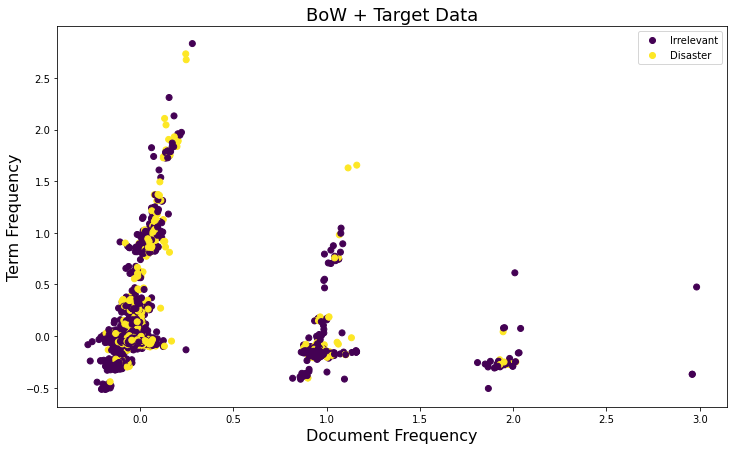

In [10]:
#This will create a PCA representation of the Count Vectorizer/ BoW
from sklearn.decomposition import PCA
from sklearn.svm import SVC
# initialize PCA with 2 components
pca = PCA(n_components=2, random_state=42)

pca.fit(countvectorizer.transform(train_df['text']).toarray())
title = ['Irrelevant', 'Disaster']
plt.figure(figsize=(12, 7))
plt.title("BoW + Target Data", fontdict={"fontsize": 18})
data2D = pca.transform(countvectorizer.transform(train_df['text']).todense())
plt.xlabel("Document Frequency", fontdict={"fontsize": 16})
plt.ylabel("Term Frequency", fontdict={"fontsize": 16})

scatter = plt.scatter(data2D[:,0],data2D[:,1], c=train_df['target'])
plt.legend(handles=scatter.legend_elements()[0], 
           labels=title)
plt.show()

/usr/local/lib/python3.9/site-packages/sklearn/utils/validation.py:727: FutureWarning: np.matrix usage is deprecated in 1.0 and will raise a TypeError in 1.2. Please convert to a numpy array with np.asarray. For more information see: https://numpy.org/doc/stable/reference/generated/numpy.matrix.html
  warnings.warn(


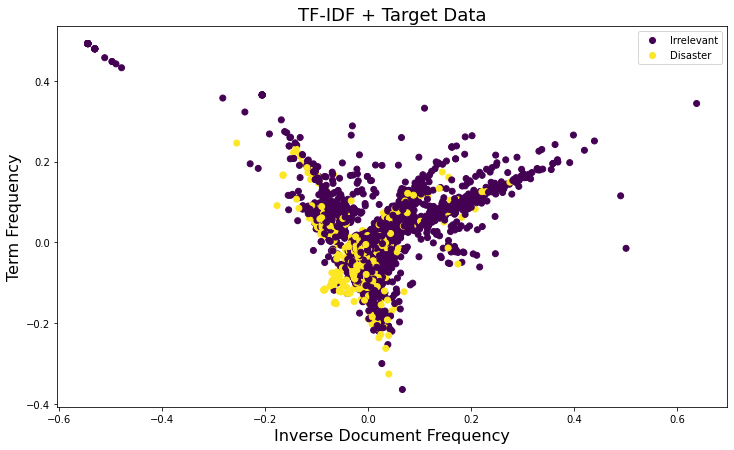

In [11]:
#This will create a PCA representation of the TF-IDF Vectorizer
from sklearn.decomposition import PCA
from sklearn.svm import SVC


# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(tfidfvectorizer.transform(train_df['text']).toarray())
# save our two dimensions into x0 and x1
x0 = pca_vecs[:, 0]
x1 = pca_vecs[:, 1]

#Store cluster data
train_df['cluster'] = clusters
train_df['x0'] = x0
train_df['x1'] = x1

# map clusters to appropriate labels 
cluster_map = {0: "Irrelevant", 1: "Disaster"}
# apply mapping
train_df['cluster'] = train_df['cluster'].map(cluster_map)



title = ['Irrelevant', 'Disaster']
plt.figure(figsize=(12, 7))
plt.title("TF-IDF + Target Data", fontdict={"fontsize": 18})
data2D = pca.transform(tfidfvectorizer.transform(train_df['text']).todense())
plt.xlabel("Inverse Document Frequency", fontdict={"fontsize": 16})
plt.ylabel("Term Frequency", fontdict={"fontsize": 16})

scatter = plt.scatter(data2D[:,0],data2D[:,1], c=train_df['target'])
plt.legend(handles=scatter.legend_elements()[0], 
           labels=title)
plt.show()

In [15]:
#This will create a K-Means clustering representation of the TFID Vectorizer
#Y-Axis = Term Frequency, X-Axis = Inverse Document Frequency

import seaborn as sns

# set image size
plt.figure(figsize=(12, 7))
# set a title
plt.title("TF-IDF + KMeans Disaster Tweet clustering", fontdict={"fontsize": 18})

# set axes names
plt.xlabel("Inverse Document Frequency", fontdict={"fontsize": 16})
plt.ylabel("Term Frequency", fontdict={"fontsize": 16})

# create scatter plot
sns.scatterplot(data=train_df, x='x0', y='x1', hue='cluster', palette="viridis")
plt.show()

ModuleNotFoundError: No module named 'seaborn'

              precision    recall  f1-score   support

           0       0.99      0.85      0.92      3196
           1       0.29      0.90      0.44       215

    accuracy                           0.86      3411
   macro avg       0.64      0.88      0.68      3411
weighted avg       0.95      0.86      0.89      3411

0.8578129580768104


[Text(0.5, 0, 'Predicted'), Text(0, 0.5, 'True')]

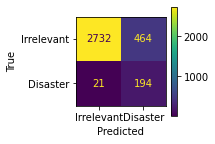

In [16]:
# Logistic Regression Model with Conf Matrix and Class Report and Accuracy

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()

lr.fit(X_train,y_train)

predictions = lr.predict(X_test)

print(classification_report(predictions, y_test))
print(accuracy_score(predictions,y_test))

confMtrx = confusion_matrix(predictions, y_test)
cmd = ConfusionMatrixDisplay(confMtrx, display_labels=['Irrelevant', 'Disaster'])
fig, ax = plt.subplots(figsize=(2,2))
cmd.plot(ax=ax)
cmd.ax_.set(xlabel='Predicted', ylabel='True')

              precision    recall  f1-score   support

           0       0.99      0.86      0.92      3174
           1       0.32      0.90      0.48       237

    accuracy                           0.86      3411
   macro avg       0.66      0.88      0.70      3411
weighted avg       0.94      0.86      0.89      3411

0.8625036646144826


[Text(0.5, 0, 'Predicted'), Text(0, 0.5, 'True')]

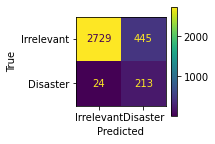

In [17]:
naive = naive_bayes.MultinomialNB()
naive.fit(X_train,y_train)

predictions = naive.predict(X_test)
print(classification_report(predictions,y_test))
print(accuracy_score(predictions,y_test))

confMtrx = confusion_matrix(predictions, y_test)
cmd = ConfusionMatrixDisplay(confMtrx, display_labels=['Irrelevant', 'Disaster'])
fig, ax = plt.subplots(figsize=(2,2))
cmd.plot(ax=ax)
cmd.ax_.set(xlabel='Predicted', ylabel='True')

              precision    recall  f1-score   support

           0       0.97      0.88      0.93      3028
           1       0.47      0.81      0.59       383

    accuracy                           0.88      3411
   macro avg       0.72      0.85      0.76      3411
weighted avg       0.92      0.88      0.89      3411

0.8759894459102903


[Text(0.5, 0, 'Predicted'), Text(0, 0.5, 'True')]

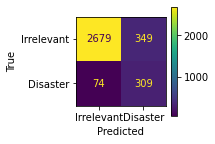

In [18]:
# SVM Model with Conf Matrix and Class Report and Accuracy

from sklearn.svm import SVC

svm = SVC(gamma='auto', kernel='linear', C=1)

svm.fit(X_train,y_train)
predictions = svm.predict(X_test)

print(classification_report(predictions, y_test))
print(accuracy_score(predictions,y_test))

confMtrx = confusion_matrix(predictions, y_test)
cmd = ConfusionMatrixDisplay(confMtrx, display_labels=['Irrelevant', 'Disaster'])
fig, ax = plt.subplots(figsize=(2,2))
cmd.plot(ax=ax)
cmd.ax_.set(xlabel='Predicted', ylabel='True')

In [19]:
# This is for custom inputs, put any data into test.csv (or whatever .csv file you want just replace 'test.csv') in the (text, target) format and it will predict your data for you


test_df = process_data('data/test.csv')

test_df['text'] = test_df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
test_df['text'] = test_df['text'].apply(lambda x: lemmatize_text(x))

y_test = encoder.transform(test_df['target'])

X_test = tfidfvectorizer.transform(test_df['text'])

/var/folders/1k/mmxb6bc53wxbhjh1vhxj380c0000gn/T/ipykernel_42553/2685552695.py:121: FutureWarning: The default value of regex will change from True to False in a future version.
  data.text = data.text.str.replace('\d+', '')  # remove numbers
/var/folders/1k/mmxb6bc53wxbhjh1vhxj380c0000gn/T/ipykernel_42553/2685552695.py:131: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['text'][sentence] = re.sub(r"http\S+", "", data['text'][sentence])
/var/folders/1k/mmxb6bc53wxbhjh1vhxj380c0000gn/T/ipykernel_42553/2685552695.py:132: FutureWarning: The default value of regex will change from True to False in a future version.
  data["text"] = data['text'].str.replace('[^\w\s]','')


In [20]:
predictions = svm.predict(X_test)

print(predictions)

[1 0 0 1 0 0 1 0 0 0 0 0]


In [21]:
import pickle

#save the model to disk
filename = 'svm_model.sav'
pickle.dump(predictions, open(filename, 'wb'))